# Test models (exponential and q)

## Import library

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr

## Setting up directory

In [2]:
data_dir = "/home/waves/projects/smap-drydown/data"
datarods_dir = "datarods"
SMAPL3_dir = r"SPL3SMP"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
PET_dir = r"PET"

import getpass
username = getpass.getuser()
formatted_now = datetime.now().strftime("%Y-%m-%d")
output_dir = rf"/home/waves/projects/smap-drydown/output/fit_models_nb_{username}_{formatted_now}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

Directory '/home/waves/projects/smap-drydown/output/fit_models_nb_raraki_2024-05-12' created.


## Read coordinate information and subset to CONUS

### Define the coordinates

In [3]:
file_path = os.path.join(data_dir, datarods_dir, "coord_info.csv")
coord_info = pd.read_csv(file_path)
file_path = os.path.join(data_dir, datarods_dir, "coord_open_water.csv")
coord_open_water = pd.read_csv(file_path)

min_lon = -125.000000
min_lat = 24.396308
max_lon = -66.934570
max_lat = 49.384358
_conus_subset = coord_info[(coord_info['latitude'] >= min_lat) &
                         (coord_info['latitude'] <= max_lat) &
                         (coord_info['longitude'] >= min_lon) &
                         (coord_info['longitude'] <= max_lon)].copy()

conus_subset = pd.merge(_conus_subset, coord_open_water, on=['EASE_row_index', 'EASE_column_index'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
print(len(conus_subset))

9596


## Sample a point

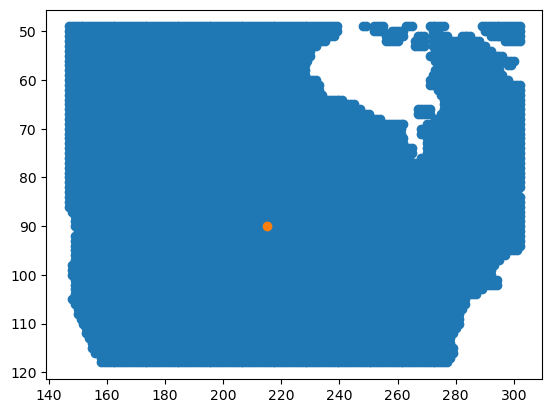

In [4]:
# SPECIFY THE INDEX (0, 9596)
p = 7000

# Plot the location
EASE_row_index = 90 #78 #53 #118 #53 #72 #conus_subset.EASE_row_index.iloc[p].copy()  215
EASE_column_index = 215 #219 #163 #215 #163 #154 #conus_subset.EASE_column_index.iloc[p].copy()
# Suspicious rod: [118,210], [118,203], [118 184],[117 200],[116 218]
# Each lower bound must be srictly .. [117,201]
# 
# print(conus_subset.iloc[p])

# Plot 
plt.scatter(conus_subset.EASE_column_index, conus_subset.EASE_row_index)
plt.scatter(EASE_column_index, EASE_row_index)
ax = plt.gca()
ax.invert_yaxis()

## Load datasets

### SMAPL3 Soil mositure data

/home/waves/projects/smap-drydown/data/datarods/SPL3SMP/SPL3SMP_090_215.csv


,Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,Soil_Moisture_Retrieval_Data_AM_soil_moisture
time,,
2015-03-31,NaN,NaN
2015-04-01,NaN,0.103092
2015-04-02,0.08755,NaN
2015-04-03,NaN,0.095468
2015-04-04,NaN,NaN


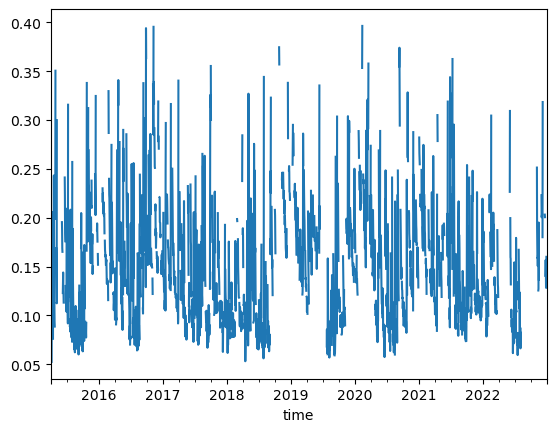

In [5]:
filename = os.path.join(data_dir, datarods_dir, SMAPL3_dir, f"SPL3SMP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
print(filename)
df = pd.read_csv(filename)

# Use retrieval flag to quality control the data
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
condition_bad_data_am = (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)
condition_bad_data_pm = (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)
df.loc[condition_bad_data_am, 'Soil_Moisture_Retrieval_Data_AM_soil_moisture'] = np.nan
df.loc[condition_bad_data_pm, 'Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'] = np.nan

# There is two different versions of 2015-03-31 data --- remove this 
duplicate_labels = df.index.duplicated(keep=False)
df = df.loc[~df.index.duplicated(keep='first')]

# Resample to regular time interval
df = df.resample('D').asfreq()

# Check if the data is all nan or not
df['Soil_Moisture_Retrieval_Data_AM_soil_moisture'].isna().all()

# Merge the AM and PM soil moisture data into one daily timeseries of data
df['soil_moisture_daily'] = df[['Soil_Moisture_Retrieval_Data_AM_soil_moisture','Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df.soil_moisture_daily.plot()

df[["Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm", "Soil_Moisture_Retrieval_Data_AM_soil_moisture"]].head()


### SMAPL4 Precipitation data

<Axes: xlabel='time'>

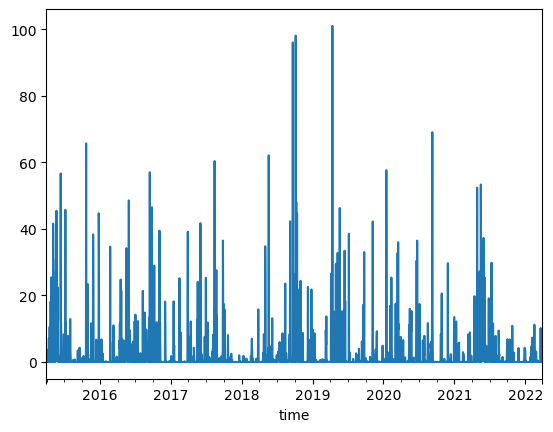

In [6]:
filename = os.path.join(data_dir, datarods_dir, SMAPL4_path, f"SPL4SMGP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
df_p = pd.read_csv(filename).drop(columns=['x','y']).rename({'precipitation_total_surface_flux': 'precip'}, axis='columns')
df_p['time'] = pd.to_datetime(df_p['time'])
df_p.set_index('time', inplace=True)

# Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
df_p.precip = df_p.precip * 86400

df_sync = pd.merge(df, df_p, how='inner', left_index=True, right_index=True)

df_sync['noprecip'] = df_sync['precip'] < 2 # < 0.00002 # Check this threshold 
df_sync['precip'].plot()

## Event separation

### Calculate dSdt

In [7]:
# Some empirical soil moisture signatures 
max_sm = df_sync.soil_moisture_daily.max()
min_sm = df_sync.soil_moisture_daily.min()
sm_range = max_sm - min_sm

# Ignore data points where data points exceed theta_star definition (95% of the historical maximum soil moisture values)
theta_star = max_sm * 0.95
print(f"Estimated theta_star is {theta_star:.2f}")
precip_thresh = 2

df_sync['soil_moisture_daily_before_masking'] = df_sync['soil_moisture_daily'].copy()
df_sync['soil_moisture_daily_masked'] = df_sync['soil_moisture_daily'].copy()
df_sync.loc[(df_sync['precip'] > precip_thresh) | (df_sync['soil_moisture_daily_before_masking'] > theta_star), 'soil_moisture_daily_masked'] = np.nan

Estimated theta_star is 0.38


In [8]:
# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
df_sync['sm_for_dS_calc'] = df_sync['soil_moisture_daily'].ffill() 

# Maximum number of days of no data where dS/dt is calculated
fill_days = 3
# Calculate dS
df_sync['dS'] = df_sync['sm_for_dS_calc'].bfill(limit=fill_days).diff().where(df_sync['sm_for_dS_calc'].notnull()).replace(0, np.nan)

# Calculate dt
nan_counts = df_sync['dS'].isnull().astype(int).groupby(df_sync['dS'].notnull().cumsum()).cumsum().shift(1)
df_sync['dt'] = nan_counts.fillna(0).astype(int) + 1

# Calculate dS/dt
df_sync['dSdt'] = df_sync['dS']/df_sync['dt']
df_sync.loc[df_sync['soil_moisture_daily'].isna(), 'dSdt'] = np.nan
df_sync['dSdt'] = df_sync['dSdt'].ffill(limit=fill_days)

df_sync[['soil_moisture_daily','soil_moisture_daily_masked', 'precip','noprecip','sm_for_dS_calc','dS', 'dt', 'dSdt']].head()


,soil_moisture_daily,soil_moisture_daily_masked,precip,noprecip,sm_for_dS_calc,dS,dt,dSdt
time,,,,,,,,
2015-03-31,NaN,NaN,1.172236e+00,True,NaN,NaN,1,NaN
2015-04-01,0.103092,0.103092,4.474586e-02,True,0.103092,NaN,2,NaN
2015-04-02,0.087550,0.087550,4.060426e-18,True,0.087550,-0.015542,3,-0.005181
2015-04-03,0.095468,0.095468,6.751228e-05,True,0.095468,0.007918,1,0.007918
2015-04-04,NaN,NaN,1.648933e+00,True,0.095468,NaN,1,0.007918


### Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- To avoid noise truncating real drydowns, any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

Add more criteria in this paper 
- At least 3 data points are available during the first 4 days of drydowns
- Ignore data points where data points exceed theta_star definition (95% of the historical maximum soil moisture values)
- Following McMoll et al (2017) paper, we do not use rainfall data for detecting drydowns, as rainfall data has its own uncertainty

In [9]:
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
noise_thresh = sm_range * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.04
dS_thresh = target_rmsd * 2

print(f"The preceding drydown should be dS > {dS_thresh:.2f}")
print(f"Drydown torelate the noise dSdt < {noise_thresh:.2f}")

The preceding drydown should be dS > 0.08
Drydown torelate the noise dSdt < 0.02


In [10]:
negative_increments = (df_sync.dSdt < 0) | (np.isnan(df_sync.dS))

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = df_sync.dS > dS_thresh

# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
# df_sync['event_start'] = (negative_increments.shift(-1).fillna(False).astype(bool) & np.concatenate(([False], positive_increments[:-1])))
df_sync['event_start'] = positive_increments #(negative_increments.shift(-1).fillna(False).astype(bool) & positive_increments.fillna(False).astype(bool))
df_sync['event_start'][df_sync['event_start']].index

DatetimeIndex(['2015-04-09', '2015-04-14', '2015-04-18', '2015-04-26',
               '2015-04-27', '2015-05-05', '2015-06-19', '2015-06-30',
               '2015-07-08', '2015-07-22',
               ...
               '2021-10-01', '2021-10-11', '2021-10-14', '2021-10-28',
               '2021-11-03', '2021-11-28', '2021-12-29', '2022-02-07',
               '2022-02-17', '2022-03-24'],
              dtype='datetime64[ns]', name='time', length=123, freq=None)

### Adjust the event start if the previous data is nan

In [11]:
df_sync.columns

Index(['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm',
       'Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm',
       'Soil_Moisture_Retrieval_Data_PM_surface_flag_pm',
       'Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag',
       'Soil_Moisture_Retrieval_Data_AM_soil_moisture',
       'Soil_Moisture_Retrieval_Data_AM_surface_flag', 'soil_moisture_daily',
       'precip', 'noprecip', 'soil_moisture_daily_before_masking',
       'soil_moisture_daily_masked', 'sm_for_dS_calc', 'dS', 'dt', 'dSdt',
       'event_start'],
      dtype='object')

# Adjust the event start (looking backwards)

In [12]:


# for i, event_start_date in enumerate(event_start_idx):
#     should_break = False
#     for j in range(0, fill_days+1): # Look back up to 3 timesteps to seek for sm value which is not nan, or start of the precip event
#         current_date = event_start_date - pd.Timedelta(days=j)

#         # If rainfall exceeds threshold, stop there
#         if (df_sync.loc[current_date].precip > precip_thresh):
#             if ~np.isnan(
#                         df_sync.loc[
#                             current_date
#                         ].soil_moisture_daily_before_masking
#                     ):
#                 update_date = event_start_date
#                 should_break = True
#                 update_arg = "precipitation threshold is reached"

#         # If max number of dais are reached, or dSdt is reached to the noise, stop there
#         if (np.isnan(df_sync.loc[current_date].dSdt)) or (df_sync.loc[current_date].dSdt<-1*noise_thresh):
#             update_date = event_start_date
#             should_break = True
#             update_arg = "dSdt is nan or dSdt is decreasing as much as noise ratio"

#         # If dSdt > 0 and SM value is not nan, use that
#         # (there was nan data in between intially identified row and previous record)
#         if (df_sync.loc[current_date].dSdt > dS_thresh) & ~np.isnan(df_sync.loc[current_date].soil_moisture_daily) & (df_sync.loc[current_date].precip < precip_thresh):
#             update_date = current_date
#             should_break = True
#             update_arg = "dSdt > threshold and SM value is not nan"

#         if should_break:
#             df_sync.loc[event_start_date, 'event_start']  = False
#             df_sync.loc[update_date, 'event_start'] = True
#             break

#     if event_start_date!=update_date:
#         print(f"{event_start_date} replaced at {update_date} ({update_arg})")
#     else:
#         print(f"{event_start_date} remains the same")

# event_start_idx = np.isnan(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
# event_start_idx

### If the soil moisture data at the beginning of the event is no data or exceeds threshold, look for subsequent available data

In [13]:
condition_mask = pd.isna(df_sync["soil_moisture_daily_masked"]) & df_sync["event_start"]
event_start_nan_idx = df_sync.index[condition_mask]

print("Indices where soil_moisture_daily_masked is NaN and event_start is True:")
print(f'{len(event_start_nan_idx)}/{len(df_sync["event_start"][df_sync["event_start"]])}')

for i, event_start_date in enumerate(event_start_nan_idx):
    print(f"processing {event_start_date}")
    current_date = event_start_date
    if (df_sync.loc[event_start_date].soil_moisture_daily_before_masking > theta_star) | (np.isnan(df_sync.loc[event_start_date].soil_moisture_daily_before_masking)) :
        current_date += pd.Timedelta(days=1)
        df_sync.loc[event_start_date, 'event_start']  = False
        df_sync.loc[current_date, 'event_start']  = True

        if (df_sync.loc[current_date].soil_moisture_daily_before_masking > theta_star) | (np.isnan(df_sync.loc[current_date].soil_moisture_daily_before_masking)):
            current_date += pd.Timedelta(days=1)
            df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
            df_sync.loc[current_date, 'event_start']  = True

            if (df_sync.loc[current_date].soil_moisture_daily_before_masking > theta_star) | (np.isnan(df_sync.loc[current_date].soil_moisture_daily_before_masking)):
                df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
                df_sync.loc[current_date, 'event_start']  = True

    if event_start_date!=current_date:
        print(f"{event_start_date} replaced at {current_date}")
    else:
        print(f"{event_start_date} remains the same")


Indices where soil_moisture_daily_masked is NaN and event_start is True:
69/123
processing 2015-04-26 00:00:00
2015-04-26 00:00:00 remains the same
processing 2015-04-27 00:00:00
2015-04-27 00:00:00 remains the same
processing 2015-05-05 00:00:00
2015-05-05 00:00:00 remains the same
processing 2015-07-08 00:00:00
2015-07-08 00:00:00 remains the same
processing 2015-07-22 00:00:00
2015-07-22 00:00:00 remains the same
processing 2015-08-01 00:00:00
2015-08-01 00:00:00 remains the same
processing 2015-09-20 00:00:00
2015-09-20 00:00:00 remains the same
processing 2015-10-23 00:00:00
2015-10-23 00:00:00 remains the same
processing 2015-12-13 00:00:00
2015-12-13 00:00:00 remains the same
processing 2016-04-13 00:00:00
2016-04-13 00:00:00 remains the same
processing 2016-04-18 00:00:00
2016-04-18 00:00:00 remains the same
processing 2016-05-18 00:00:00
2016-05-18 00:00:00 remains the same
processing 2016-05-30 00:00:00
2016-05-30 00:00:00 remains the same
processing 2016-07-16 00:00:00
2016-

### If rainfall is persistent (not one day), move the start dates

In [14]:
event_start_idx = df_sync["event_start"][
                df_sync["event_start"]
            ].index
            
for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    current_date = event_start_date + pd.Timedelta(days=1)
    if (df_sync.loc[current_date].precip > precip_thresh):
        current_date += pd.Timedelta(days=1)
        df_sync.loc[event_start_date, 'event_start']  = False
        df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
        df_sync.loc[current_date, 'event_start']  = True

        if (df_sync.loc[current_date].precip > precip_thresh):
            current_date += pd.Timedelta(days=1)
            df_sync.loc[event_start_date, 'event_start']  = False
            df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
            df_sync.loc[current_date, 'event_start']  = True

    if event_start_date!=current_date:
        print(f"{event_start_date} replaced at {current_date}")
    else:
        print(f"{event_start_date} remains the same")


processing 2015-04-09 00:00:00
2015-04-09 00:00:00 replaced at 2015-04-10 00:00:00
processing 2015-04-14 00:00:00
2015-04-14 00:00:00 replaced at 2015-04-15 00:00:00
processing 2015-04-18 00:00:00
2015-04-18 00:00:00 replaced at 2015-04-19 00:00:00
processing 2015-04-26 00:00:00
2015-04-26 00:00:00 replaced at 2015-04-29 00:00:00
processing 2015-04-27 00:00:00
2015-04-27 00:00:00 replaced at 2015-04-29 00:00:00
processing 2015-05-05 00:00:00
2015-05-05 00:00:00 replaced at 2015-05-08 00:00:00
processing 2015-06-19 00:00:00
2015-06-19 00:00:00 replaced at 2015-06-20 00:00:00
processing 2015-06-30 00:00:00
2015-06-30 00:00:00 replaced at 2015-07-01 00:00:00
processing 2015-07-08 00:00:00
2015-07-08 00:00:00 replaced at 2015-07-10 00:00:00
processing 2015-07-22 00:00:00
2015-07-22 00:00:00 replaced at 2015-07-23 00:00:00
processing 2015-08-01 00:00:00
2015-08-01 00:00:00 replaced at 2015-08-03 00:00:00
processing 2015-09-20 00:00:00
2015-09-20 00:00:00 replaced at 2015-09-21 00:00:00
proc

### If dS is still increasing, move the start dates

In [15]:
event_start_idx = df_sync["event_start"][
                df_sync["event_start"]
            ].index

for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    current_date = event_start_date + pd.Timedelta(days=1)
    if (df_sync.loc[current_date].dS > 0):
        current_date += pd.Timedelta(days=1)
        df_sync.loc[event_start_date, 'event_start']  = False
        df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
        df_sync.loc[current_date, 'event_start']  = True

        if (df_sync.loc[current_date].dS > 0):
            current_date += pd.Timedelta(days=1)
            df_sync.loc[event_start_date, 'event_start']  = False
            df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
            df_sync.loc[current_date, 'event_start']  = True

            if (df_sync.loc[current_date].dS > 0):
                current_date += pd.Timedelta(days=1)
                df_sync.loc[event_start_date, 'event_start']  = False
                df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
                df_sync.loc[current_date, 'event_start']  = True

                if (df_sync.loc[current_date].dS > 0):
                    current_date += pd.Timedelta(days=1)
                    df_sync.loc[event_start_date, 'event_start']  = False
                    df_sync.loc[current_date - pd.Timedelta(days=1), 'event_start']  = False
                    df_sync.loc[current_date, 'event_start']  = True

    if event_start_date!=current_date:
        print(f"{event_start_date} replaced at {current_date}")
    else:
        print(f"{event_start_date} remains the same")


processing 2015-04-09 00:00:00
2015-04-09 00:00:00 replaced at 2015-04-10 00:00:00
processing 2015-04-14 00:00:00
2015-04-14 00:00:00 replaced at 2015-04-15 00:00:00
processing 2015-04-18 00:00:00
2015-04-18 00:00:00 replaced at 2015-04-19 00:00:00
processing 2015-04-29 00:00:00
2015-04-29 00:00:00 replaced at 2015-04-30 00:00:00
processing 2015-05-08 00:00:00
2015-05-08 00:00:00 replaced at 2015-05-09 00:00:00
processing 2015-06-19 00:00:00
2015-06-19 00:00:00 replaced at 2015-06-20 00:00:00
processing 2015-06-30 00:00:00
2015-06-30 00:00:00 replaced at 2015-07-01 00:00:00
processing 2015-07-10 00:00:00
2015-07-10 00:00:00 replaced at 2015-07-11 00:00:00
processing 2015-07-22 00:00:00
2015-07-22 00:00:00 replaced at 2015-07-23 00:00:00
processing 2015-08-03 00:00:00
2015-08-03 00:00:00 replaced at 2015-08-05 00:00:00
processing 2015-09-20 00:00:00
2015-09-20 00:00:00 replaced at 2015-09-22 00:00:00
processing 2015-10-02 00:00:00
2015-10-02 00:00:00 replaced at 2015-10-03 00:00:00
proc

In [16]:
event_start_idx = np.isnan(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
event_start_idx

DatetimeIndex(['2015-04-09', '2015-04-14', '2015-04-18', '2015-04-29',
               '2015-05-08', '2015-06-19', '2015-06-30', '2015-07-10',
               '2015-07-22', '2015-08-05',
               ...
               '2021-08-16', '2021-10-03', '2021-10-14', '2021-10-28',
               '2021-11-03', '2021-11-28', '2021-12-29', '2022-02-09',
               '2022-02-17', '2022-03-24'],
              dtype='datetime64[ns]', name='time', length=116, freq=None)

### Iterate through each row to find event end

In [41]:
df_sync['event_end'] = np.zeros(len(df_sync), dtype=bool)
event_start_idx = pd.Series(df_sync['event_start'][df_sync['event_start']].index)
event_end_idx = pd.Series([pd.NaT] * len(df_sync['event_start']))
record_last_date = df_sync.index.values[-1]
record_start_date = df_sync.index.values[0]

for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    remaining_records = record_last_date - event_start_date + pd.Timedelta(days=1)
    count_nan_days = 0
    should_break = False

    for j in range(1, remaining_records.days):
        current_date = event_start_date + pd.Timedelta(days=j)

        if np.isnan(df_sync.loc[current_date].soil_moisture_daily):
            count_nan_days +=1
        else:
            count_nan_days=0

        if  (df_sync.loc[current_date].precip >= precip_thresh):
            update_date = current_date -  pd.Timedelta(days=1)
            update_arg = "precipitation exceeds threshold"
            should_break = True

        if count_nan_days > fill_days:
            update_date = current_date
            update_arg = "too many consective nans"
            should_break = True

        if (df_sync.loc[current_date].dS >= noise_thresh): # & (~np.isnan(df_sync.loc[current_date].soil_moisture_daily)): 
            # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
            update_date = current_date -  pd.Timedelta(days=1)
            update_arg = "dS increment exceed the noise threshold"
            should_break = True

        if current_date == record_last_date: 
            update_date = record_last_date
            update_arg = "Reached the end of the record"
            should_break = True

        if should_break:
            df_sync.loc[update_date, 'event_end'] = True
            print(f"end reached at {update_date} {update_arg}")
            event_end_idx[i] = update_date
            break

# create a new column for event_end
df_sync['dSdt(t-1)'] = df_sync.dSdt.shift(+1)

processing 2015-04-09 00:00:00
end reached at 2015-04-12 00:00:00 precipitation exceeds threshold
processing 2015-04-14 00:00:00
end reached at 2015-04-16 00:00:00 precipitation exceeds threshold
processing 2015-04-18 00:00:00
end reached at 2015-04-21 00:00:00 precipitation exceeds threshold
processing 2015-04-29 00:00:00
end reached at 2015-05-03 00:00:00 precipitation exceeds threshold
processing 2015-05-08 00:00:00
end reached at 2015-05-08 00:00:00 precipitation exceeds threshold
processing 2015-06-19 00:00:00
end reached at 2015-06-28 00:00:00 precipitation exceeds threshold
processing 2015-06-30 00:00:00
end reached at 2015-07-05 00:00:00 precipitation exceeds threshold
processing 2015-07-10 00:00:00
end reached at 2015-07-20 00:00:00 precipitation exceeds threshold
processing 2015-07-22 00:00:00
end reached at 2015-07-30 00:00:00 precipitation exceeds threshold
processing 2015-08-05 00:00:00
end reached at 2015-08-13 00:00:00 dS increment exceed the noise threshold
processing 2

In [42]:
len(event_start_idx)

116

In [43]:
print([event_start_idx, event_end_idx])

[0     2015-04-09
1     2015-04-14
2     2015-04-18
3     2015-04-29
4     2015-05-08
         ...    
111   2021-11-28
112   2021-12-29
113   2022-02-09
114   2022-02-17
115   2022-03-24
Name: time, Length: 116, dtype: datetime64[ns], 0      2015-04-12
1      2015-04-16
2      2015-04-21
3      2015-05-03
4      2015-05-08
          ...    
2552          NaT
2553          NaT
2554          NaT
2555          NaT
2556          NaT
Length: 2557, dtype: datetime64[ns]]


In [44]:
df_sync[['soil_moisture_daily','precip','noprecip','sm_for_dS_calc','dS', 'dt', 'dSdt', 'event_start', 'event_end']]['2020-11-20':'2020-12-10']

,soil_moisture_daily,precip,noprecip,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end
time,,,,,,,,,
2020-11-20,0.122555,7.302818e-19,True,0.122555,-0.011481,2,-0.005740,False,False
2020-11-21,0.126502,2.832256e-09,True,0.126502,0.003946,1,0.003946,False,False
2020-11-22,0.122318,1.057374e-02,True,0.122318,-0.004183,1,-0.004183,False,False
2020-11-23,0.120762,3.308012e-02,True,0.120762,-0.001556,1,-0.001556,False,False
2020-11-24,0.119296,8.671305e-02,True,0.119296,-0.001467,1,-0.001467,False,False
2020-11-25,0.125592,9.069956e-14,True,0.125592,0.006297,1,0.006297,False,False
2020-11-26,0.120456,5.715379e-24,True,0.120456,-0.005136,1,-0.005136,False,False
2020-11-27,NaN,3.735628e-15,True,0.120456,NaN,1,-0.005136,False,True
2020-11-28,0.105221,2.966068e+01,False,0.105221,-0.015235,2,-0.007618,False,False


### Remove data above theta_star

In [45]:
df_sync["sm_for_modelfit"] = df_sync['soil_moisture_daily'].where(df_sync['soil_moisture_daily'] <= theta_star)
sum(df_sync["sm_for_modelfit"] > theta_star)

0

### Get normalized SM

In [46]:
df_sync['normalized_S'] = (df_sync.sm_for_modelfit - min_sm)/(max_sm - min_sm)

### Plot

(16709.0, 17074.0)

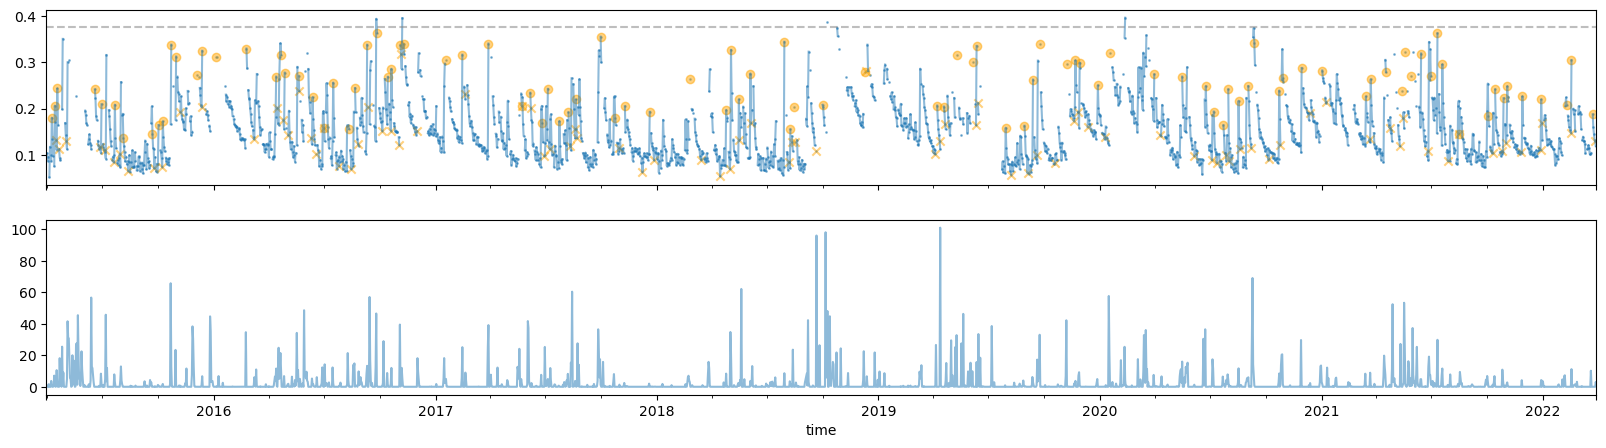

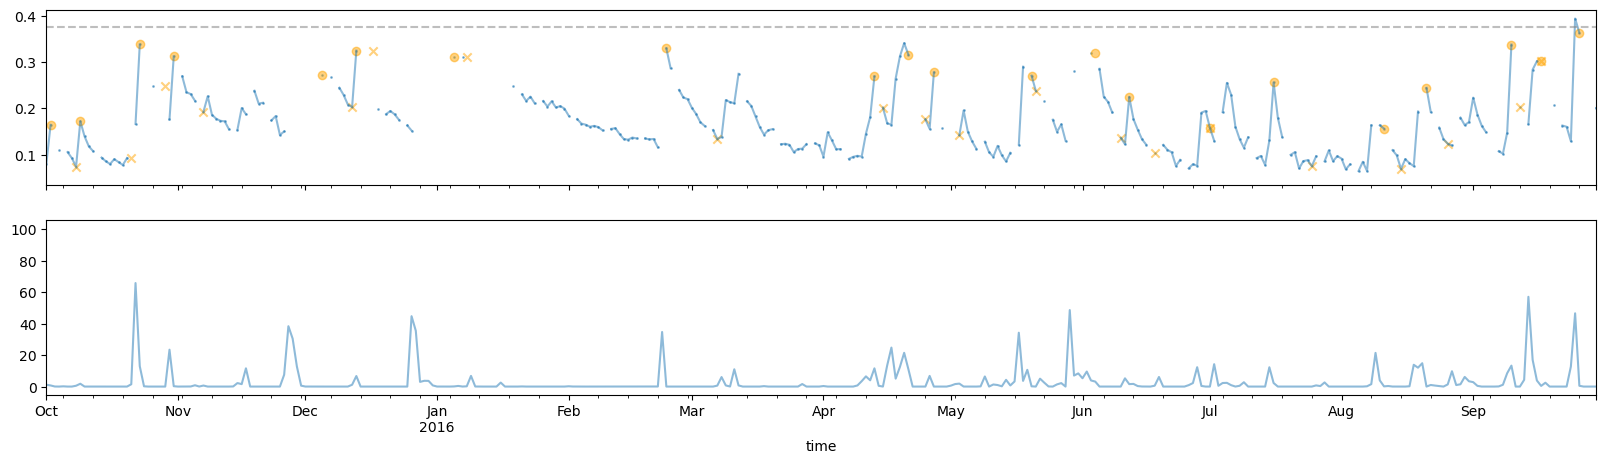

In [47]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ax11.scatter(df_sync.index, df_sync['soil_moisture_daily'], color='tab:blue', alpha=0.5, s=1)
df_sync.soil_moisture_daily.plot(ax=ax11,  color='tab:blue', alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_start']], df_sync['soil_moisture_daily'][df_sync['event_start']], color='orange', alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_end']], df_sync['soil_moisture_daily'][df_sync['event_end']], color='orange', marker='x', alpha=0.5)
ax11.axhline(y = theta_star, color = 'tab:grey', linestyle = '--', alpha=0.5) 
# ax11.set_xlim('2019', '2020')
df_sync.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_timeseries.png'))

fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ax21.scatter(df_sync.index, df_sync['soil_moisture_daily'], color='tab:blue', alpha=0.5, s=1)
df_sync.soil_moisture_daily.plot(ax=ax21, alpha=0.5 , color='tab:blue',)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_start']].index, df_sync.soil_moisture_daily.ffill()[df_sync['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_end']].index, df_sync.soil_moisture_daily.ffill()[df_sync['event_end']].values, color='orange', marker='x', alpha=0.5)
ax21.axhline(y = theta_star, color = 'tab:grey', linestyle = '--', alpha=0.5) 
df_sync.precip.plot(ax=ax22, alpha=0.5)

plot_year = 2015
ax22.set_xlim([datetime(plot_year, 10, 1), datetime(plot_year+1, 9, 30)])

## Check dataframe

In [24]:

df_sync[["soil_moisture_daily","precip", "dS", "dt","dSdt","event_start", "event_end"]]['2022-03-01':'2022-04-30']

,soil_moisture_daily,precip,dS,dt,dSdt,event_start,event_end
time,,,,,,,
2022-03-01,0.205218,7.184036e-17,0.016556,1,0.016556,False,False
2022-03-02,0.191347,5.535981e-10,-0.013872,1,-0.013872,False,False
2022-03-03,0.193010,3.675872e-11,0.001663,1,0.001663,False,False
2022-03-04,0.187360,1.640909e-12,-0.005650,1,-0.005650,False,False
2022-03-05,0.156013,0.000000e+00,-0.031346,1,-0.031346,False,False
2022-03-06,NaN,4.193312e-01,NaN,1,-0.031346,False,False
2022-03-07,0.131574,1.643917e-06,-0.024439,2,-0.012220,False,False
2022-03-08,0.139234,1.538217e-08,0.007660,1,0.007660,False,False
2022-03-09,0.130702,5.777728e-14,-0.008532,1,-0.008532,False,False


### Separate into events

In [25]:
# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'sm': list(df_sync.loc[start_index:end_index, 'sm_for_modelfit'].values),
               'precip': list(df_sync.loc[start_index:end_index, 'precip'].values),
               'normalized_S': list(df_sync.loc[start_index:end_index, 'normalized_S'].values),
               'delta_theta': df_sync.loc[start_index, 'dSdt(t-1)'],
               } 
               for start_index, end_index in zip(event_start_idx, event_end_idx)]
event_df = pd.DataFrame(event_data)

min_consective_days = 4
event_df_long = event_df[event_df['sm'].apply(lambda x: pd.notna(x).sum()) >= min_consective_days].copy()
event_df_long = event_df_long.reset_index(drop=True)
len(event_df_long)
print(event_df[["event_start","event_end", "sm"]])
# # Filtering condition
# min_consective_days_for_event_start = 3
# # Apply a filter to check the first 3 entries are not NaN
# event_df_long = event_df_long[event_df_long['sm'].apply(lambda x: pd.Series(x[:3]).notna().all())].copy()
# event_df_long = event_df_long.reset_index(drop=True)

    event_start  event_end                                                 sm
0    2015-04-09 2015-04-12          [0.18009013, 0.13409312, 0.09797663, nan]
1    2015-04-14 2015-04-16               [0.20607723, 0.17183557, 0.13163663]
2    2015-04-18 2015-04-21         [0.24328342, 0.16459279, nan, 0.112281054]
3    2015-04-29 2015-05-03     [nan, nan, 0.16870624, 0.14337873, 0.12981993]
4    2015-05-08 2015-05-08                                              [nan]
..          ...        ...                                                ...
111  2021-11-28 2021-12-28  [0.2262378, 0.16401853, nan, 0.13678598, 0.136...
112  2021-12-29 2021-12-30                            [0.21948168, 0.1692158]
113  2022-02-09 2022-02-16  [0.2067567, nan, 0.18477331, 0.1746808, 0.1607...
114  2022-02-17 2022-02-25  [0.30452865, nan, nan, 0.19939429, 0.18739997,...
115  2022-03-24 2022-03-28  [0.18737274, 0.1589901, 0.14519120000000002, 0...

[116 rows x 3 columns]


## Fit models to drydown curve

### Calculate tau & q

In [26]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

### Expontnetial model

In [27]:
# # Function for exponential model
# def exp_model(t, delta_theta, theta_w, tau):
#     return delta_theta * np.exp(-t/tau) + theta_w

def exponential_model(t, delta_theta, theta_w, tau):
    """
    Calculate the drydown curve for soil moisture over time using non-linear plant stress model.

    Parameters:
        t (int): Timestep, in day.
        delta_theta (float): Shift/increment in soil moisture after precipitation, in m3/m3.
        theta_w (float, optional): Wilting point soil moisture content, equal to s_star * porosity, in m3/m3. Default is 0.0.
        tau (float): decay rate, in 1/day.

    Returns:
        float: Rate of change in soil moisture (dtheta/dt) for the given timestep, in m3/m3/day.

    Reference:
        McColl, K.A., W. Wang, B. Peng, R. Akbar, D.J. Short Gianotti, et al. 2017.
        Global characterization of surface soil moisture drydowns.
        Geophys. Res. Lett. 44(8): 3682–3690. doi: 10.1002/2017GL072819.
    """
    return delta_theta * np.exp(-t / tau) + theta_w

In [28]:
PET = 10

In [29]:
# Fit exponential model to each drydown event
opt_model = 'OLSE'
drydown_params = []

for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    sm_subset = np.asarray(row['normalized_S'])
    t = np.arange(0, len(sm_subset),1)
    min_norm_sm_subset = np.nanmin(sm_subset)
    max_norm_sm_subset = np.nanmax(sm_subset)
    sm_subset_range = max_norm_sm_subset - min_norm_sm_subset
    x = t[~np.isnan(sm_subset)]
    y = sm_subset[~np.isnan(sm_subset)]

    ### Delta_theta ###
    min_delta_theta = sm_subset_range - target_rmsd*2
    max_delta_theta = sm_subset_range + target_rmsd*2
    ini_delta_theta = sm_subset_range

    ### Theta_w ###
    min_theta_w = 0
    max_theta_w = min_norm_sm_subset
    ini_theta_w = (min_theta_w + max_theta_w) / 2

    ### Tau ###
    min_tau = 50 * (max_sm - min_sm) / PET #0
    max_tau = np.inf
    ini_tau = min_tau * 2

    bounds = [
        (min_delta_theta, min_theta_w, min_tau),
        (max_delta_theta, max_theta_w, max_tau),
    ]
    p0 = [ini_delta_theta, ini_theta_w, ini_tau]

    try: 
        # Fit the data
        popt, pcov = curve_fit(f=exponential_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = exponential_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        
    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()

,event_start,event_end,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-06-19,2015-06-28,0.454739,0.112214,4.107873,0.976093,"[0.5669524865640524, 0.46869726513491505, 0.39..."
1,2015-06-30,2015-07-05,0.314207,0.134026,1.718954,0.981719,"[0.44823222720923883, 0.23218106310365466, 0.1..."
2,2015-07-10,2015-07-20,0.408659,0.083984,5.047962,0.847414,"[0.35895945327934825, 0.30954314165084895, 0.2..."
3,2015-07-22,2015-07-30,0.360790,0.072574,1.718954,0.928559,"[0.4333640229352791, 0.27422674014193094, 0.18..."
4,2015-08-05,2015-08-13,0.202309,0.037015,3.709833,0.909118,"[0.2393233665658359, 0.19152191482568176, 0.15..."


In [30]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit

,event_start,event_end,sm,precip,normalized_S,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-06-19,2015-06-28,"[0.24122249, 0.22286707, 0.18386002, 0.1759449...","[0.019728143200149536, 0.0007116179749023411, ...","[0.5489466729874484, 0.495555426607633, 0.3820...",NaN,0.112214,4.107873,0.976093,"[0.5669524865640524, 0.46869726513491505, 0.39..."
1,2015-06-30,2015-07-05,"[0.20916444, nan, 0.12324255, 0.11608986, 0.11...","[1.8578223865932804, 8.988150139388863e-06, 9....","[0.45569796246998606, nan, 0.2057730466462465,...",-0.013245,0.134026,1.718954,0.981719,"[0.44823222720923883, 0.23218106310365466, 0.1..."
2,2015-07-10,2015-07-20,"[nan, nan, 0.1965966, 0.1828883, 0.15614234, 0...","[0.007569626736331471, 2.3337652239661713e-06,...","[nan, nan, 0.41914131370345836, 0.379267356978...",0.223742,0.083984,5.047962,0.847414,"[0.35895945327934825, 0.30954314165084895, 0.2..."
3,2015-07-22,2015-07-30,"[0.2082759, 0.13563368, 0.114705764, nan, 0.08...","[2.9141730978658495, 2.16119649604378e-06, 2.2...","[0.4531134256923846, 0.2418156909853202, 0.180...",0.015201,0.072574,1.718954,0.928559,"[0.4333640229352791, 0.27422674014193094, 0.18..."
4,2015-08-05,2015-08-13,"[0.13567525, 0.1196374, 0.10520185, 0.08575781...","[2.471104807872842e-14, 1.0592782500696277e-23...","[0.24193660753814264, 0.1952865825998672, 0.15...",0.003612,0.037015,3.709833,0.909118,"[0.2393233665658359, 0.19152191482568176, 0.15..."
...,...,...,...,...,...,...,...,...,...,...
64,2021-11-03,2021-11-26,"[0.24815843, 0.21710263, 0.2239082, nan, 0.165...","[2.7724766417551447, 0.3565385865945567, 0.038...","[0.5691215576490696, 0.4787881373665444, 0.498...",0.017220,0.140993,5.797314,0.963834,"[0.5658278178865386, 0.49851857627494367, 0.44..."
65,2021-11-28,2021-12-28,"[0.2262378, 0.16401853, nan, 0.13678598, 0.136...","[6.3253018655975946e-15, 0.0, 5.65644218662345...","[0.5053600225204389, 0.3243799973212198, nan, ...",-0.002893,0.123519,4.985979,0.828684,"[0.43478486664903965, 0.3782187016862261, 0.29..."
66,2022-02-09,2022-02-16,"[0.2067567, nan, 0.18477331, 0.1746808, 0.1607...","[2.3522806437918573e-19, 6.115950121602112e-07...","[0.44869445944153247, nan, 0.3847503714417173,...",0.018041,0.199121,5.973790,0.987468,"[0.45052345872458327, 0.3789954037636973, 0.35..."
67,2022-02-17,2022-02-25,"[0.30452865, nan, nan, 0.19939429, 0.18739997,...","[11.18301323674176, 0.0, 0.0, 1.33039461588145...","[0.7330881846455856, nan, nan, 0.4272790820620...",-0.007178,0.232754,3.593882,0.944906,"[0.7306149143619404, 0.44881692011725505, 0.39..."


### q model

In [31]:
def q_model(t, k, q, delta_theta, theta_star=1.0, theta_w=0.0):
    """
    Calculate the drydown curve for soil moisture over time using non-linear plant stress model.

    Parameters:
        t (int): Timestep, in day.
        k (float): Product of soil thickness (z) and maximum rate of change in normalized soil moisture (k), equivalent to maximum ET rate (ETmax), in m3/m3/day.
        q (float): Degree of non-linearity in the soil moisture response.
        delta_theta (float): Shift/increment in soil moisture after precipitation, in m3/m3. It is equal to theta_0 - theta_w.
        theta_star (float, optional): Critical soil moisture content, equal to s_star * porosity, in m3/m3. Default is 1.0.
        theta_w (float, optional): Wilting point soil moisture content, equal to s_star * porosity, in m3/m3. Default is 0.0.

    Returns:
        float: Rate of change in soil moisture (dtheta/dt) for the given timestep, in m3/m3/day.
    """

    b = delta_theta ** (1 - q)

    a = (1 - q) / ((theta_star - theta_w) ** q)

    return (-k * a * t + b) ** (1 / (1 - q)) + theta_w

In [32]:
drydown_params = []
for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    sm_subset = np.asarray(row['normalized_S'])
    #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
    t = np.arange(0, len(sm_subset),1)
    sm_subset_range = np.nanmax(sm_subset) - np.nanmin(sm_subset)
    sm_subset_min = np.nanmin(sm_subset)
    sm_subset_max = np.nanmax(sm_subset)
    x = t[~np.isnan(sm_subset)]
    y = sm_subset[~np.isnan(sm_subset)]
    
    # Define the bounds
    # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
    # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
    
    ### k (should be close to PET/z ###
    min_k = 0
    max_k = PET / 50 / (max_sm - min_sm)
    ini_k = max_k * 0.5

    ### q ###
    min_q = 0
    max_q = np.inf
    ini_q = 1.0 + 1.0e-03

    ### delta_theta ###
    min_delta_theta = sm_subset_max - target_rmsd
    max_delta_theta = sm_subset_max + target_rmsd #1 #.0  # Equivalent of self.data.range_sm as the input theta values are normalized in this code
    ini_delta_theta = sm_subset_max

    bounds = [(min_k, min_q, min_delta_theta), (max_k, max_q, max_delta_theta)]
    p0 = [ini_k, ini_q, ini_delta_theta]
    
    try: 
        # Fit the model
        popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = q_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'q__k': popt[0], 'q__q': popt[1], 'q__delta_theta': popt[2], 'q__r_squared': r_squared, 'q__opt_drydown': y_opt.tolist()})

    except Exception as e:
        print(f"An error occurred at index {index}: {e}")
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()
event_df_with_curvefit = pd.merge(event_df_with_curvefit, drydown_params_df, on=['event_start', 'event_end'], how='outer')

In [33]:
max_k

0.5817491114865829

In [34]:
max_sm - min_sm

0.34379081300000003

In [35]:
event_df_with_curvefit.columns

Index(['event_start', 'event_end', 'sm', 'precip', 'normalized_S',
       'delta_theta', 'theta_w', 'tau', 'r_squared', 'opt_drydown', 'q__k',
       'q__q', 'q__delta_theta', 'q__r_squared', 'q__opt_drydown'],
      dtype='object')

### Plot and save

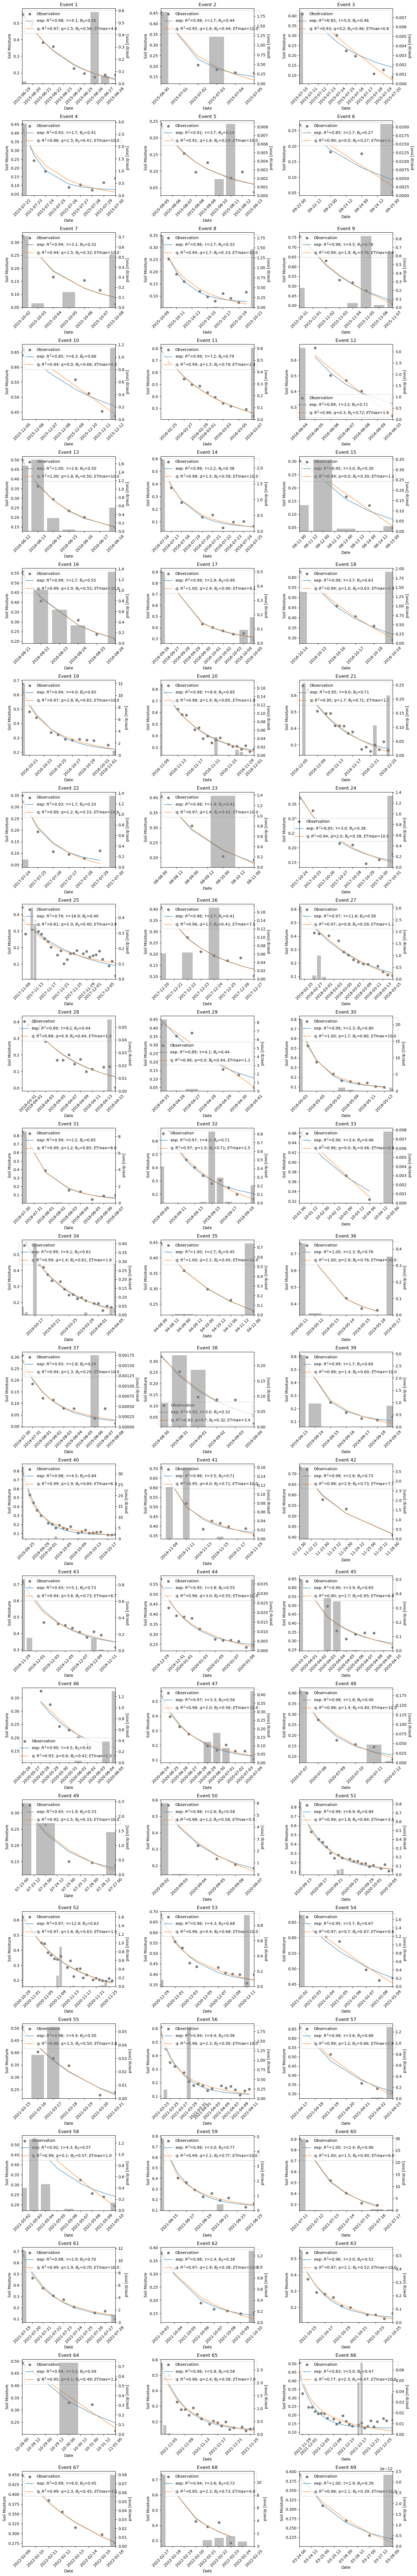

In [36]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 3
num_rows = (num_events + num_cols - 1) // num_cols  # This ensures an extra row if there's a remainder

# Plot each event as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=False, figsize=(15, 4 * num_rows))
axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure axes is always 2D

for index, row in event_df_with_curvefit.iterrows():
    ax = axes[index // num_cols, index % num_cols]

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['normalized_S'])
    y_opt = np.asarray(row['opt_drydown'])
    y_opt__q = np.asarray(row['q__opt_drydown'])
    precip = np.asarray(row['precip'])
    r_squared = row['r_squared']
    q__r_squared = row['q__r_squared']
    q = row['q__q']
    tau = row['tau']
    theta_0 = row['q__delta_theta']

    ETmax = row['q__k'] * 50 * (max_sm - min_sm)

    ax.scatter(x, y, label='Observation', color='tab:grey')
    if ~np.all(np.isnan(y_opt)):
        ax.plot(x[~np.isnan(y)], y_opt, alpha=.7, label=rf'exp: $R^2$={r_squared:.2f}; $\tau$={tau:.1f}; $\theta_0$={theta_0:.2f}', color='tab:blue')
    if ~np.all(np.isnan(y_opt__q)):
        ax.plot(x[~np.isnan(y)], y_opt__q, alpha=.7, label=rf'q: $R^2$={q__r_squared:.2f}; $q$={q:.1f}; $\theta_0$={theta_0:.2f}; $ETmax$={ETmax:.1f}', color='tab:orange')

    ax.set_title(f'Event {index+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Soil Moisture')
    ax.set_xlim([row['event_start'], row['event_end']])
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

    # Plotting precio on the secondary y-axis
    ax2 = ax.twinx()
    ax2.bar(x, precip, align='center', color='tab:grey', alpha=0.5, label='Precipitation')
    ax2.set_ylabel('precip [mm]')


# Hide any unused axes
for ax in axes.flat[index+1:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()

In [37]:
# row = event_df_long.iloc[1]

# # Read the data
# start_date = row['event_start']
# end_date = row['event_end']
# delta_theta = row['delta_theta']
# norm_S = row['normalized_S']
# sm_subset = np.asarray(row['normalized_S'])
# PET = 10 #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
# t = np.arange(0, len(sm_subset),1)
# soil_moisture_range = np.nanmax(sm_subset) - np.nanmin(sm_subset)
# sm_subset_min = np.nanmin(sm_subset)
# sm_subset_max = np.nanmax(sm_subset)
# x = t[~np.isnan(sm_subset)]
# y = sm_subset[~np.isnan(sm_subset)]

# ############ exponential model ######################


# ############ q model ######################
# # Define the bounds
# # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
# # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
# epsilon = 1.0E-10
# bounds  = [(0., 0., 0., 0., 0), (PET*10, 10, 1., 1., 1.)]
# p0      = [PET, 1. + 1.E-03, soil_moisture_range, 0.5, 1.0E-5]

# # Fit the model
# popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
# # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
# # pcov: The estimated covariance of popt

# # Reroduce the analytical solution and calculate the residuals
# y_opt = q_model(x, *popt)
# residuals = y - y_opt
# ss_res = np.sum(residuals ** 2)
# ss_tot = np.sum((y - np.nanmean(y)) ** 2)
# r_squared = 1 - (ss_res / ss_tot)

# # Convert drydown parameters to DataFrame
# plt.scatter(x, y)
# plt.plot(x, y_opt)